# Time series decomposition

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib as mpl
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from random import randrange
from pandas import Series
from statsmodels.tsa.stattools import adfuller

In [100]:
#nhập bảng subs
df_s= pd.read_csv('daily_subs_fillna1.csv')
df_s.head()

,date,subs
0,2021-04-01,2973
1,2021-04-02,2864
2,2021-04-03,3014
3,2021-04-04,3118
4,2021-04-05,2894


In [101]:
#chuyển thành kiểu datetime
df_s['date']= pd.to_datetime(df_s['date'])

In [102]:
#tạo cột tháng
def get_month(x):
    return pd.Timestamp(x.year, x.month, 1)
df_s['month']= df_s['date'].apply(get_month)
df_s.head()

,date,subs,month
0,2021-04-01,2973,2021-04-01
1,2021-04-02,2864,2021-04-01
2,2021-04-03,3014,2021-04-01
3,2021-04-04,3118,2021-04-01
4,2021-04-05,2894,2021-04-01


In [103]:
df_sub= df_s.groupby('month')['subs'].sum().reset_index()
df_sub

,month,subs
0,2021-04-01,100489
1,2021-05-01,151130
2,2021-06-01,191557
3,2021-07-01,342261
4,2021-08-01,348864
5,2021-09-01,298636
6,2021-10-01,252237
7,2021-11-01,206021
8,2021-12-01,200404
9,2022-01-01,197485


In [104]:
# Kiểm tra tính dừng bằng ADF test
result = adfuller(df_sub['subs'])

# Trích xuất kết quả
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

# In kết quả
print("ADF Statistic:", adf_statistic)
print("p-value:", p_value)
print("Critical Values:")
for key, value in critical_values.items():
    print("\t{}: {}".format(key, value))

ADF Statistic: -2.7341817886595026
p-value: 0.06830778667337468
Critical Values:
	1%: -3.769732625845229
	5%: -3.005425537190083
	10%: -2.6425009917355373


## Seasonality (tính chu kỳ, mùa vụ)

Yếu tố chu kỳ và mùa vụ là một thông tin quan trọng vì nó thể hiện những qui luật lặp lại tác động tới chuỗi thời gian. Tìm ra được qui luật của chuỗi thời gian theo chu kỳ và mùa vụ sẽ giúp cho chúng ta dự báo chính xác hơn.

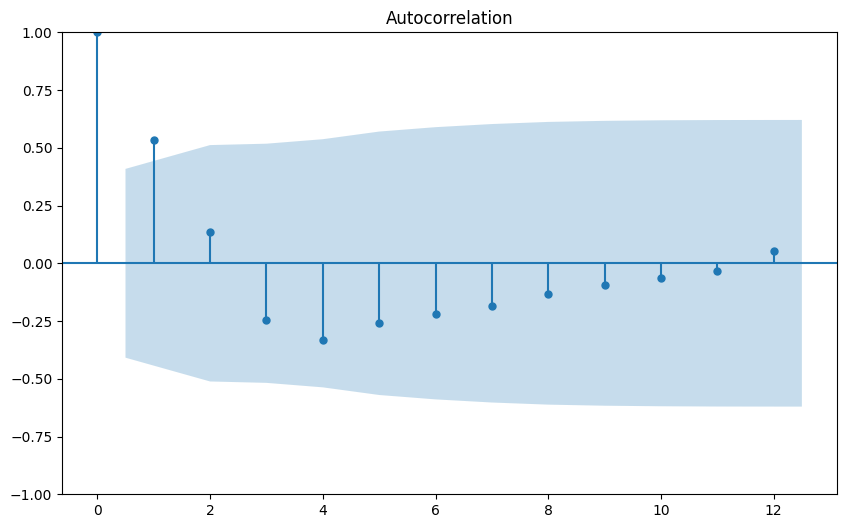

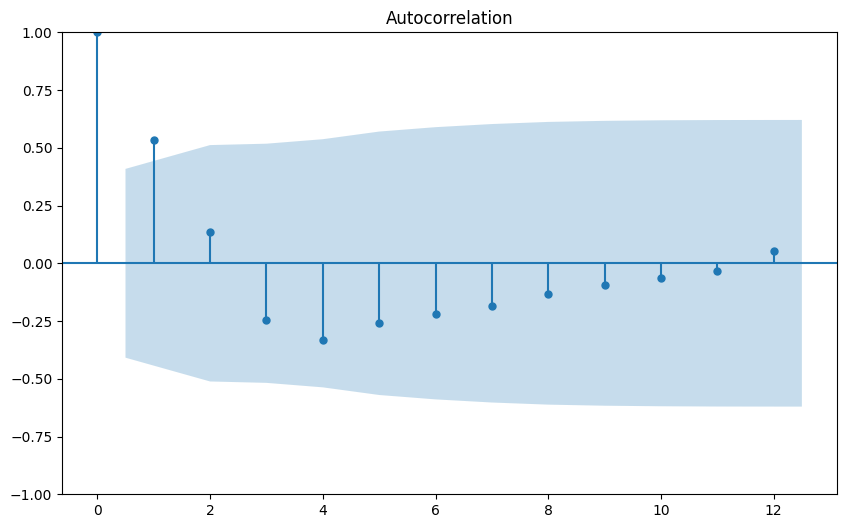

In [105]:
mpl.rc("figure", figsize=(10, 6))
plot_acf(df_sub["subs"], lags = 12)

Trục y
 đại diện cho hệ số tương quan và trục x
 đại diện cho độ trễ. Độ dài của các thanh vuông góc với trục x
 thể hiện giá trị của hệ số tương quan tương ứng với độ trễ đó (tạm gọi là hệ số tương quan trễ)

Không có chu kỳ nào trong vòng 1 năm

## Trung bình trượt

Trung bình trượt là phương pháp làm mịn chuỗi bằng cách lấy trung bình của chuỗi trong một khung thời gian. Trung bình trượt có tác dụng theo dõi giao động trong ngắn hạn và nhận biết được xu hướng trong dài hạn của chuỗi.

Trung bình trượt theo cấp số nhân đặt trọng số vào các giá trị gần đây hơn dạng trung bình trượt đơn. Do đó có khả năng nắm bắt tốt chuyển động của xu hướng

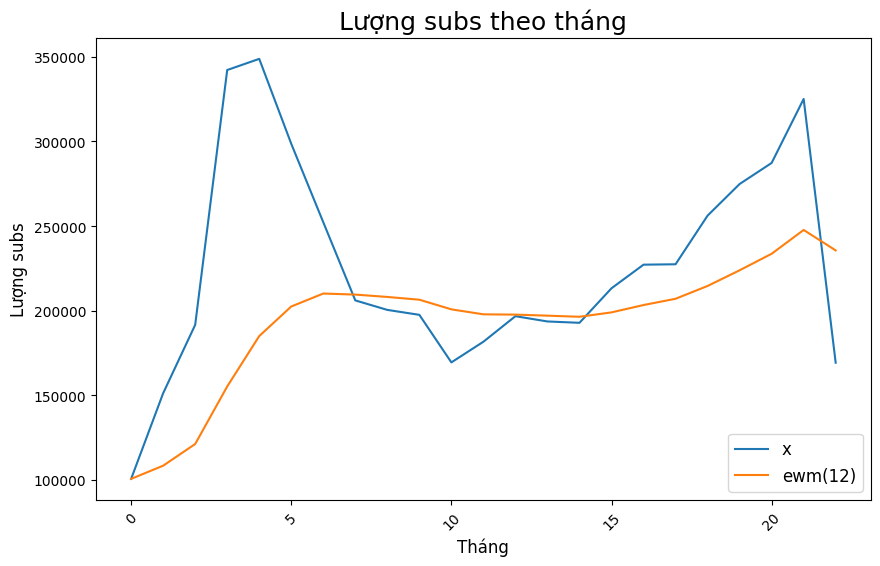

In [106]:
# Caculate exponential moving average
df_sub.reset_index(inplace=True)
df_ewm = df_sub['subs'].ewm(span=12, adjust=False).mean()

plt.figure(figsize=(10, 6))
plt.plot(df_sub['index'], df_sub['subs'], label="x")
plt.plot(df_sub['index'], df_ewm, label="ewm(12)")
plt.xticks(rotation=45)
plt.xlabel('Tháng', fontsize=12)
plt.ylabel('Lượng subs', fontsize=12)
plt.legend(fontsize=12)
plt.title('Lượng subs theo tháng', fontsize=18)
plt.show()

### Loại bỏ tính xu hướng

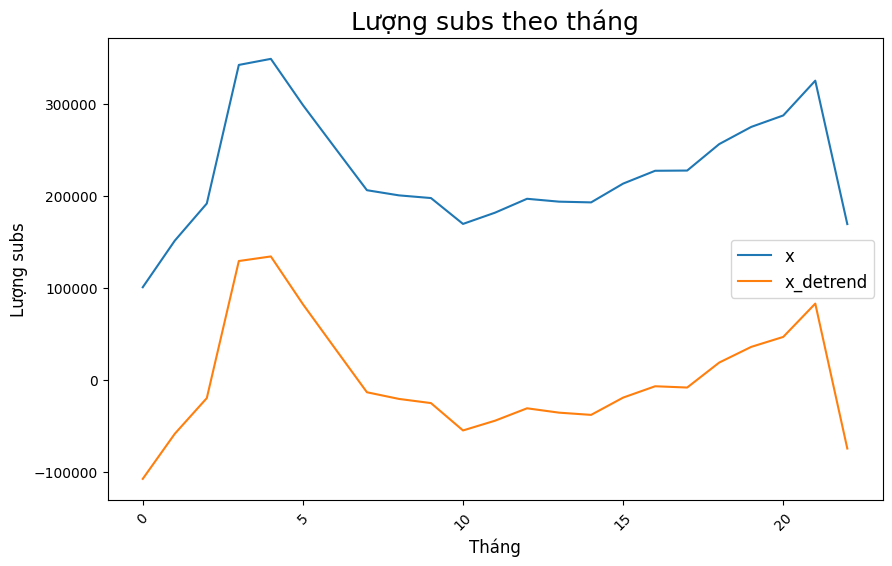

In [107]:
x_detrend = signal.detrend(df_sub['subs'])
df_detrend = pd.DataFrame({"subs_detrend": x_detrend}, index=df_sub.index)

plt.figure(figsize=(10, 6))
plt.plot(df_sub['subs'], label="x")
plt.plot(df_detrend, label="x_detrend")
plt.xticks(rotation=45)
plt.xlabel('Tháng', fontsize=12)
plt.ylabel('Lượng subs', fontsize=12)
plt.legend(fontsize=12)
plt.title('Lượng subs theo tháng', fontsize=18)
plt.show()

## Tách các yếu tố season và trend để quan sát

In [108]:
new_row = {'month':'2023-03-01', 'subs':323569}  
df_sub.loc[len(df_sub)] = new_row
df_sub= df_sub[['month','subs']]
df_sub

,month,subs
0,2021-04-01 00:00:00,100489
1,2021-05-01 00:00:00,151130
2,2021-06-01 00:00:00,191557
3,2021-07-01 00:00:00,342261
4,2021-08-01 00:00:00,348864
5,2021-09-01 00:00:00,298636
6,2021-10-01 00:00:00,252237
7,2021-11-01 00:00:00,206021
8,2021-12-01 00:00:00,200404
9,2022-01-01 00:00:00,197485


Thêm dữ liệu tháng 3-2023 để đảm bảo bộ dữ liệu có đủ dữ liệu của 24 tháng. Bởi vì phải đảm bảo dữ liệu đủ số tháng của 1 năm, 2 năm hoặc 3 năm để sử dụng hàm seasonal_decompose trong thư viện statsmodels.tsa.seasonal. Số lượng subs tháng 03-2023 được tạm tính bằng subs tháng 02-2023 cộng thêm cho độ chênh lệch giữa subs tháng 01 và tháng 02-2023.

In [109]:
df_sub['month']= pd.to_datetime(df_sub['month'])

C:\Users\hangu\AppData\Local\Temp\ipykernel_20492\605958094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['month']= pd.to_datetime(df_sub['month'])


C:\Users\hangu\AppData\Local\Temp\ipykernel_20492\4269067724.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['month'] = pd.to_datetime(df_sub['month'])


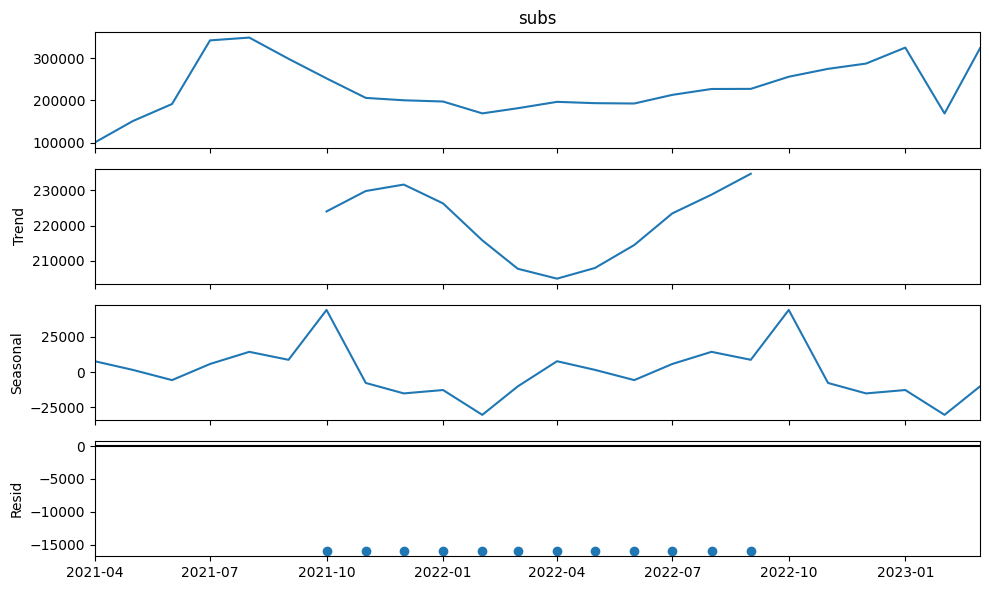

In [110]:
# Chuyển đổi dữ liệu thành thời gian
df_sub['month'] = pd.to_datetime(df_sub['month'])
df_sub.set_index('month', inplace=True)

result = seasonal_decompose(df_sub['subs'], model='additive')
result.plot()
plt.show()